In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import cv2

In [ ]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, stride=1):
        super().__init__()
        padding = kernel_size // 2
        self.conv = torch.nn.Conv2d(in_c, out_c, kernel_size, stride, padding, bias=False)
        self.bn = torch.nn.BatchNorm2d(out_c)
        self.act = torch.nn.LeakyReLU(0.1)
    def forward(self, x): return self.act(self.bn(self.conv(x)))

class ResidualBlock(torch.nn.Module):
    def __init__(self, in_c):
        super().__init__()
        self.layer = torch.nn.Sequential(
            ConvBlock(in_c, in_c // 2, 1),
            ConvBlock(in_c // 2, in_c, 3)
        )
    def forward(self, x): return x + self.layer(x)

class Darknet53(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 64, 3, 2),
            ResidualBlock(64)
        )
        self.layer2 = torch.nn.Sequential(
            ConvBlock(64, 128, 3, 2),
            *[ResidualBlock(128) for _ in range(2)]
        )
        self.layer3 = torch.nn.Sequential(
            ConvBlock(128, 256, 3, 2),
            *[ResidualBlock(256) for _ in range(8)]
        )
        self.layer4 = torch.nn.Sequential(
            ConvBlock(256, 512, 3, 2),
            *[ResidualBlock(512) for _ in range(8)]
        )
        self.layer5 = torch.nn.Sequential(
            ConvBlock(512, 1024, 3, 2),
            *[ResidualBlock(1024) for _ in range(4)]
        )
    def forward(self, x):
        for l in [self.layer1, self.layer2, self.layer3, self.layer4, self.layer5]:
            x = l(x)
        return x

class AttentionModule(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.gamma = torch.nn.Parameter(torch.zeros(1))
    def forward(self, x):
        attn = torch.softmax(x.view(x.size(0), -1), dim=1).view_as(x)
        return x + self.gamma * attn * x

class AttentionYOLOv3(torch.nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.backbone = Darknet53()
        self.attn = AttentionModule(1024)
        self.gap = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(1024, num_classes)
    def forward(self, x):
        feat = self.backbone(x)
        feat = self.attn(feat)
        out = self.gap(feat).flatten(1)
        logits = self.fc(out)
        return logits

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionYOLOv3(num_classes=2).to(device)

In [ ]:
files.upload()

Saving attention_yolov3_drowsy_8epochs.pth to attention_yolov3_drowsy_8epochs.pth


In [ ]:
model.load_state_dict(torch.load("/content/attention_yolov3_drowsy_8epochs.pth", map_location=device))
model.eval()

AttentionYOLOv3(
  (backbone): Darknet53(
    (layer1): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): LeakyReLU(negative_slope=0.1)
      )
      (1): ConvBlock(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): LeakyReLU(negative_slope=0.1)
      )
      (2): ResidualBlock(
        (layer): Sequential(
          (0): ConvBlock(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): LeakyReLU(negative_slope=0.1)
          )
          (1): ConvBlock(
            (conv): Conv2d(32, 64, kernel_size=(3, 3), stri

In [ ]:
transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
def predict_image(img_path):
    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)[0]
        pred_idx = torch.argmax(probs).item()

    classes = ["drowsy", "notdrowsy"]
    print(f"Prediction: {classes[pred_idx]}")
    print(f"Confidence → Drowsy: {probs[0]:.3f}, NotDrowsy: {probs[1]:.3f}")

    plt.imshow(np.array(image))
    plt.title(f"{classes[pred_idx]} ({probs[pred_idx]*100:.1f}%)")
    plt.axis('off')
    plt.show()

In [ ]:
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raghavendarkotha","key":"2d8e3375795968fd0ef2f321aafa715a"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d banudeep/nthuddd2

Dataset URL: https://www.kaggle.com/datasets/banudeep/nthuddd2
License(s): unknown
100% 2.80G/2.81G [00:53<00:00, 62.2MB/s]
100% 2.81G/2.81G [00:54<00:00, 55.3MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile("nthuddd2.zip", 'r') as zip_ref:
    zip_ref.extractall("nthu-dataset")

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        for name, module in self.model.named_modules():
            if name == self.target_layer:
                module.register_forward_hook(forward_hook)
                module.register_backward_hook(backward_hook)
                break

    def __call__(self, x, class_idx=None):
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        loss = output[:, class_idx]
        self.model.zero_grad()
        loss.backward()

        gradients = self.gradients
        activations = self.activations

        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1).squeeze().cpu().numpy()
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (x.shape[2], x.shape[3]))
        cam = cam / cam.max()
        return cam

In [ ]:
target_layer = "backbone.layer5.4.layer.1.conv"
cam_extractor = GradCAM(model, target_layer)


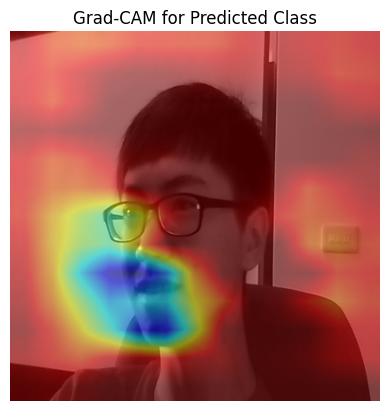

In [ ]:
img_path = "/content/nthu-dataset/train_data/notdrowsy/001_glasses_nonsleepyCombination_4_notdrowsy.jpg"
img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# ---- Generate CAM ----
cam = cam_extractor(input_tensor)

# ---- Overlay CAM on image ----
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
img_np = np.array(img.resize((416, 416))) / 255.0
overlay = 0.5 * heatmap + 0.5 * img_np
overlay = np.clip(overlay, 0, 1)

# ---- Show ----
plt.imshow(overlay)
plt.title("Grad-CAM for Predicted Class")
plt.axis('off')
plt.show()

Prediction: notdrowsy
Confidence → Drowsy: 0.426, NotDrowsy: 0.574


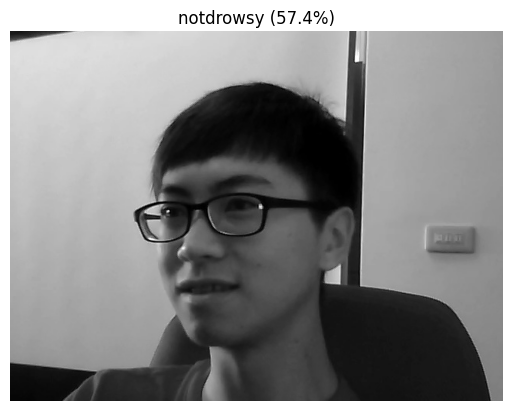

In [ ]:
predict_image(img_path)